# Transformer model (GPT) from scratch

GPT (Not "THE ChatGPT") is a Large Language Model (LLM) made by OpenAI back in 2018. Its architecture is based on the decoder-based transformer model from [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) paper.

- Why a Language Model? -> Bcoz it just predicts and generates the next word for a given input sequence of words.
- Why not "THE ChatGPT"? -> Bcoz its just a text generator, not someone to chat with. ChatGPT is a conversational app built on top of GPT.
- Why Large? -> Bcoz its basically a large neural network with millions (billions for SOTA models) of parameters.

We will rather train a simpler and smaller model of our own.
___

### But why transformers?

Earlier RNN based language models like GRU or LSTM process text word-by-word due to which they faced challenges like:
- long-term memory loss as information from the beginning of a long sentence often fades or gets lost ("vanishing gradient problem") by the time the model reaches the end.
- were very slow to train or infer due to their sequential nature of processing.  

Transformer model solved these problems by leveraging attention mechanism which mathematically is just a matrix multiplication thus allowing parallel processing of entire text sequence at once. This enables self-attention to look at all the words in the sequence at the same time for getting context.
___

### 1. Dataset preparation

Models like GPTs were trained on massive internet data. We will use a simple and tiny dataset which basically consists of Shakespeare literature.

Typical dataset preparation involves **tokenization**. It is the process of splitting a text sequence into samller chunks (like splitting a sentence into words) which are converted to numbers (integers) bcoz neural networks being a mathematical model (doing some matrix multiplications and additions) work with numbers. These numbers (or tokens) are what a language model takes as input and generates as output. Thus we  need to encode the text sequences into list of tokens for the input and decode the predicted tokens back to original text sequence for the textoutput.

Tokenization itself is a hell of a process. Modern tokenization techniques use BPE (Byte Pair Encoding) algorithm which iteratively merges the most frequently occurring pairs of characters or bytes into new, single units producing sub-word tokens e.g. "ing", "ment", "er", etc.

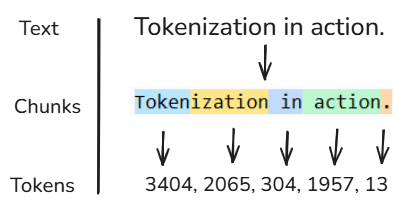

Want to see it live, just click here 👉 [Tiktokenizer](https://tiktokenizer.vercel.app/).

We will instead follow a simple tokenization process where we tokenize each character. Thus every unique character in the dataset will be considered as a single token. Thus our model will work with character-level tokens and once trained it will generate text character-by-character but in Shakespeare style.

#### 1.1 Loading dataset

In [ ]:
with open("data/tiny_shakespeare.txt", encoding="utf-8") as f:
    text = f.read()

print(text[:1000]) # first 1000 characters

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
len(text) # 1M+ character-level tokens

1115394

#### 1.2 Creating vocabulary

In [ ]:
chars = sorted(set(''.join(text))) # getting all unique characters
vocab_size = len(chars) # total unique characters/tokens
print(chars)
print(vocab_size)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


#### 1.3 Creating encoder and decoder

In [ ]:
# character to integer mappings
ch_to_i = {ch: i for i, ch in enumerate(chars)}
i_to_ch = {i: ch for i, ch in enumerate(chars)}
print(ch_to_i)
print(i_to_ch)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

In [ ]:
# defining encoder and docoder
encode = lambda str: [ch_to_i[ch] for ch in str] # takes a string -> returns list of integers/tokens
decode = lambda ints: ''.join(i_to_ch[i] for i in ints) # takes a list of integers/tokens -> returns a string

# testing
decode(encode("Hello World!")) # YEH! it works.

'Hello World!'

#### 1.4 Converting tokens to a PyTorch tensor object

Why tensor object? -> Bcoz models created using PyTorch use tensors as datatypes which not only store data but also store the gradients required for training optimization.

***Note:** Here we are using `torch.long` data type for our tensor object. This is required in order to index embeddings from the embedding matrix that we will use later.*

In [ ]:
import torch

# encode text to tokens and store into a torch.tensor object
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
data[:100] # first 100 tokens

torch.Size([1115394]) torch.int64


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [ ]:
print(f"First 10 characters (original): {text[:10]}")
print(f"First 10 characters (tokenized): {data[:10].tolist()}")
print("Character to token mapping:")
for ch in list(text[:10]):
    print(f"char = '{ch}' | token = {ch_to_i[ch]}")

First 10 characters (original): First Citi
First 10 characters (tokenized): [18, 47, 56, 57, 58, 1, 15, 47, 58, 47]
Character to token mapping:
char = 'F' | token = 18
char = 'i' | token = 47
char = 'r' | token = 56
char = 's' | token = 57
char = 't' | token = 58
char = ' ' | token = 1
char = 'C' | token = 15
char = 'i' | token = 47
char = 't' | token = 58
char = 'i' | token = 47


#### 1.5 Spitting dataset

We use 90% of our data for training (to tune model parameters) and 10% for validation (to tune hyperparameters).

In [ ]:
# splitting data into training & validation sets
n = int(0.9 * len(data))
train_data = data[:n] # 90% of data for training
val_data = data[n:] # 10% of data for validation

#### 1.6 Defining context length

Context length is the maximum no. tokens given as input to the model. Larger context length allows more tokens to be fed into the model thus the model can have more context while predicting next token.

It is a hyperparameter, means its value needs to be emperically set to tune model performance.

We will start with a context length of 8. This means that for the given 8 characters (or tokens as we are using character level tokens) as input our model will predict the 9th token as output. We can gradually scale it up once we are confident of our model implementation.

In [ ]:
# defining context length
block_size = 8
train_data[:block_size+1] # block size is the max input sequence, +1 is the target

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

Training on all 8 individual examples is not only efficient but also helps the model adapt to predicting output during inference for the given input sequence of any length between 1 to block size.

#### 1.7 Visualising input sequence and targets

In [ ]:
# Visualizing 8 individual examples packed within the sequence of 9 characters as raw text
x = text[:block_size] # inputs
y = text[1:block_size+1] # targets
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is '{context}' the target is '{target}'")

when input is 'F' the target is 'i'
when input is 'Fi' the target is 'r'
when input is 'Fir' the target is 's'
when input is 'Firs' the target is 't'
when input is 'First' the target is ' '
when input is 'First ' the target is 'C'
when input is 'First C' the target is 'i'
when input is 'First Ci' the target is 't'


In [ ]:
# Visualizing 8 individual examples packed within the sequence of 9 characters as tokens
x = train_data[:block_size] # inputs
y = train_data[1:block_size+1] # targets
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context.tolist()} the target is {target}")

when input is [18] the target is 47
when input is [18, 47] the target is 56
when input is [18, 47, 56] the target is 57
when input is [18, 47, 56, 57] the target is 58
when input is [18, 47, 56, 57, 58] the target is 1
when input is [18, 47, 56, 57, 58, 1] the target is 15
when input is [18, 47, 56, 57, 58, 1, 15] the target is 47
when input is [18, 47, 56, 57, 58, 1, 15, 47] the target is 58


#### 1.8 Creating batches

Why batches? Training on entire dataset at once can be extremely slow especially if the model is too large (compute intensive).   Instead training on random subsets of data is faster.

A single batch contains ***batch size*** no. of example sequences each with `context length = block size` stacked up together into a tensor. Each sequence in the batch will be processed parallelly by the GPU. Each sequence contains 8 individual examples.

So for `batch size = 4` and `block size = 8`, there are 32 examples.

In [ ]:
# creating batches
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for making a prediction?
device = 'cuda' if torch.cuda.is_available() else 'cpu' # use gpu if available

print(f"device = {device}")

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, size=(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch('train')
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)
for b in range(batch_size):
    print("--------------------------------------------------------------")
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target is {target}")

device = cuda
inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')
--------------------------------------------------------------
when input is [24] the target is 43
when input is [24, 43] the target is 58
when input is [24, 43, 58] the target is 5
when input is [24, 43, 58, 5] the target is 57
when input is [24, 43, 58, 5, 57] the target is 1
when input is [24, 43, 58, 5, 57, 1] the target is 46
when input is [24, 43, 58, 5, 57, 1, 46] the target is 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target is 39
--------------------------------------------------------------
when input is [44] the target is 53
when in

___
### 2. Bigram model

We will first start with super simple bigram langauge model that uses a lookup table to get the **logits** *(raw model outputs on which we will apply softmax to get probability distribution)* for making a prediction.

> A bigram langauge model basically predicts the next char/word in a sequence only on the the basis of last char/word. Basically it just looks at the very last char/word of the sequence to get context when making predictions for the next char/word.

A character-level bigram language model usually counts the frequencies for all possible character pairs from the dataset and store into a counts table like below:
| |a|b|c|...|z|
|-|-|-|-| - |-|
|a|2|13|4|...|0|
|b|24|7|1|...|0|
|c|5|5|0|...|2|
|...|...|...|...|...|...|
|z|5|0|1|...|1|

with each cell having the count for character pairs. For any input character the model just gets the whole row to get frequency counts for all possible pairs starting with that input character. Then the model just calculates probabilities from those counts and select a next character.

Since we are using neural networks, instead of counting and storing character pair frequencies into a table we will use a simple lookup table (or embedding matrix) of same dimensions and expect its parameters to learn the values similar to the count values during training.

This model will serve as the baseline for our transformer model.

#### 2.1 Defining code structure

We will use Pytorch `nn.Module` to define our language model class. Our class will have 3 methods:
1. `__init__` method: to initialize the module parameters
2. `forward` method: which will take the inputs and return the logits and the loss
3. `generate` method: to generate new tokens for the max limit

The implementation of the ***generate*** method in this model seems irrelevant as its taking a sequence of tokens within a batch as input but only the last token in the sequence is being used for the prediction. Its intuitive that a bigram model only needs a single input token to predict the next token but here its taking a sequence of tokens. This is done with a purpose to have a similar implementation of the method for the later transformer model which will consider the history of tokens instead of just the last token to predict the next token in the sequence.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

class BasicGPT(nn.Module):
	def __init__(self):
		super().__init__()
		# each token directly reads off the logits for the next token from a lookup table
		self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

	def forward(self, idx, targets=None):
		# idx (inputs) and targets are both (B, T) tensor of integers
		logits = self.token_embedding_table(idx) # (B, T, C)
		loss = None
		if targets is not None:
			# Re-shaping is required to conform dimensions for calculating F.cross_entropy
			B, T, C = logits.shape
			logits = logits.view(B*T, C)
			targets = targets.view(B*T)
			loss = F.cross_entropy(logits, targets)
		return logits, loss

	def generate(self, idx, max_new_tokens):
		# idx (inputs) is of shape (B, T)
		for _ in range(max_new_tokens):
			# get predictions
			logits, loss = self(idx) # (B, T, C)
			# focus only on the last time step or the last value in the sequence within the batch
			logits = logits[:, -1, :] # becomes (B, C)
			# apply softmax to get probabilities along the last dim i.e. C
			probs = F.softmax(logits, dim=-1) # (B, C)
			# sample from the distribution to get next prediction in the sequence
			idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
			# append sampled index to the running sequence
			idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

		return idx


model = BasicGPT().to(device)
logits, loss = model(xb, yb)
print(logits.shape)

torch.Size([32, 65])


___
Inputs have the shape of (B, T) containing B*T individual examples.

Logits have shape of (B, T, C) where B represents the batch dimension, T represents the time/sequence dimension and C represents the no. of channels or classes.

For the given dimension values:  
B = batch_size = 4,  
T = block_size = 8,  
C = vocab_size = 65  

**Original:**
logits.shape = [4, 8, 65]  
**After reshaping (during loss calulation):**
logits.shape = [32, 65]  

In the `generate` method, the logits shape is (B, T, C) but since we are predicting next token based on the logits given by last token only, the shape changes to (B, C).

For every batch out of 4 batches, for last token in the sequence -> take the all 65 logits (or embeddings since we are directly indexing them from the table as of now):  
b1 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
b2 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
b3 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
b4 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
where `t8` has 65 values corresponding to each character in the vocabulary. Thus the shape changes to (B, C).

***Note:** Even though we are providing 8 tokens as context still our prediction is solely based on the logits given by last token becoz there is no shared context or no communication is happening among the tokens as of now. Every token is independently indexing its own set of logits directly from the embedding matrix. Thus the logits produced for the last token got the context for only that token.*
___

In [ ]:
probs = F.softmax(logits, dim=-1)
observed_mean_prob = probs[torch.arange(32), yb.view(-1)].mean()

print(f"Expected probability: {1/65}")
print(f"Observed probability: {observed_mean_prob}")
print("Expected initial loss:", -torch.log(torch.tensor(1/65)).item())
print("Observed initial loss:", loss.item())

Expected probability: 0.015384615384615385
Observed probability: 0.01053521316498518
Expected initial loss: 4.174387454986572
Observed initial loss: 4.878634929656982


In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = decode(model.generate(context, max_new_tokens=100)[0].tolist())
print(f"Text generation at random model params (no training):{output}")

Text generation at random model params (no training):
pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


___
**Generation:** As of now the model generates gibberish bcoz the model is just randomly initialized. The model needs to learn to align its neurons in a sematically correct way in order to make any sensible output. This will improve after training.
___

#### 2.2 Training our bigram model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

# hyperparameters
batch_size = 32
block_size = 8
learning_rate = 1e-2
max_iters = 3000
eval_interval = 300
eval_iters = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"device = {device}")

# loading text data
with open('data/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
	text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(set(text))
vocab_size = len(chars)

# create character to integer / integer to character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# encoding entire datset and storing it into a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Splitting data in training and validation sets
n = int(0.9*len(data)) # first 90% of data is for training, rest is for validation
train_data = data[:n]
val_data = data[n:]

# create batches
def get_batch(split):
	data = train_data if split == 'train' else val_data
	ix = torch.randint(len(data)-block_size, size=(batch_size,))
	x = torch.stack([data[i:i+block_size] for i in ix])
	y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
	x, y = x.to(device), y.to(device)
	return x, y


class BasicGPT(nn.Module):
	def __init__(self):
		super().__init__()
		# each token directly reads off the logits for the next token from a lookup table
		self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

	def forward(self, idx, targets=None):
		# idx (inputs) and targets are both (B, T) tensor of integers
		logits = self.token_embedding_table(idx) # (B, T, C)
		loss = None
		if targets is not None:
			# Re-shaping is required to conform dimensions for calculating F.cross_entropy
			B, T, C = logits.shape
			logits = logits.view(B*T, C)
			targets = targets.view(B*T)
			loss = F.cross_entropy(logits, targets)
		return logits, loss

	def generate(self, idx, max_new_tokens):
		# idx (inputs) is of shape (B, T)
		for _ in range(max_new_tokens):
			# get predictions
			logits, loss = self(idx) # (B, T, C)
			# focus only on the last time step or the last value in the sequence within the batch
			logits = logits[:, -1, :] # becomes (B, C)
			# apply softmax to get probabilities along the last dim i.e. C
			probs = F.softmax(logits, dim=-1) # (B, C)
			# sample from the distribution to get next prediction in the sequence
			idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
			# append sampled index to the running sequence
			idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

		return idx


model = BasicGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
	out = {}
	model.eval()
	for split in ['train', 'val']:
		losses = torch.zeros(eval_iters)
		for k in range(eval_iters):
			xb, yb = get_batch(split)
			logits, loss = model(xb, yb)
			losses[k] = loss.item()
		out[split] = losses.mean()
	model.train()
	return out


for iter in range(max_iters):
	 # every once in a while evaluate loss on train and val sets
	if iter % eval_interval == 0:
		losses = estimate_loss()
		print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

	# sample a batch
	xb, yb = get_batch('train')
	# forward pass
	logits, loss = model(xb, yb)
	# set gradients to None
	optimizer.zero_grad(set_to_none=True)
	# backward pass
	loss.backward()
	# update
	optimizer.step()

losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

# generate from the model
print("\n------------------------------- GENERATION -------------------------------\n")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

device = cuda
step 0: train loss 4.7305, val loss 4.7241
step 300: train loss 2.8110, val loss 2.8249
step 600: train loss 2.5434, val loss 2.5682
step 900: train loss 2.4932, val loss 2.5088
step 1200: train loss 2.4863, val loss 2.5035
step 1500: train loss 2.4665, val loss 2.4921
step 1800: train loss 2.4683, val loss 2.4936
step 2100: train loss 2.4696, val loss 2.4846
step 2400: train loss 2.4638, val loss 2.4879
step 2700: train loss 2.4738, val loss 2.4911
step 2999: train loss 2.4613, val loss 2.4897

------------------------------- GENERATION -------------------------------




CEThik brid owindakis b, bth

HAPet bobe d e.
S:
O:3 my d?
LUCous:
Wanthar u qur, t.
War dXENDoate awice my.

Hastarom oroup
Yowhthetof isth ble mil ndill, ath iree sengmin lat Heriliovets, and Win nghir.
Swanousel lind me l.
HAshe ce hiry:
Supr aisspllw y.
Hentofu n Boopetelaves
MPOLI s, d mothakleo Windo whth eisbyo the m dourive we higend t so mower; te

AN ad nterupt f s ar igr t m:

Thin maleronth,

#### 2.3 Baseline results

**final loss:** train loss 2.4613, val loss 2.4897

This is our baseline loss. We will try to surpass this loss with our transformer based implementation.

___
### 3. Transformer model (GPT)

#### Define model architecture

A typical decoder-based transformer architecture is like this. Refer [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) paper.

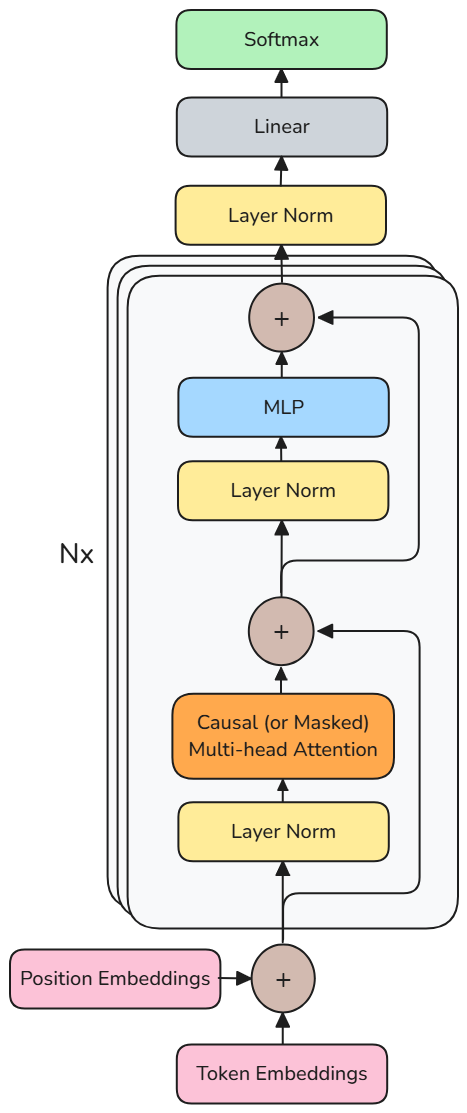

We will incrementally add transformer layers to our previous bigram model. Our code progression will look like this:

1. token embeddings
3. positional encodings
4. single-head of self-attention
5. multi-head attention
6. feed-forward layer (MLP)
7. transformer block
8. layernorm + residual connections

#### 3.1 Token Embeddings

Why use embeddings?

A token is represented by a single unique number only. One single number (or single dimension) cannot help the model assign any semantic meaning to it. But representing it with list of numbers (or vectors) can help the model to look into various dimensions to get different features for that token. These embeddings represent meanings of a word. More embeddings will help the model better interpret these meanings.
___
We will use our bigram model implementation from above and make 2 changes to it:

1. Add a new hyperparameter `n_embd` (no. of embedding dimensions). And use it in embedding table. Thus, every token in vocabulary will have `n_embd` no. of dimensions.

    ***Dimensions**: Input dim(B, T) -> Embedding table -> Output dim(B, T, C), where C = n_embd*

2. Add a linear layer (called **language model head**) after embedding layer. Since output from the embedding table will have different dimension than the needed `vocab_size` for predictions, we need to squeeze it down to `vocab_size` no. of dimensions by passing the embeddings from this linear layer. The output from this layer will be our logits.

    ***Dimensions**: Input dim(B, T, n_embd) -> LM Head -> Output dim(B, T, vocab_size)*

Code changes:

```
class BasicGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx (inputs) and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C) where C = n_embd
        logits = self.lm_head(tok_emb) # (B, T, vocab_size)
```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

# hyperparameters
batch_size = 32
block_size = 8
learning_rate = 1e-2
max_iters = 3000
eval_interval = 300
eval_iters = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 32

print(f"device = {device}")

# loading text data
with open('data/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
	text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(set(text))
vocab_size = len(chars)

# create character to integer / integer to character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# encoding entire datset and storing it into a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Splitting data in training and validation sets
n = int(0.9*len(data)) # first 90% of data is for training, rest is for validation
train_data = data[:n]
val_data = data[n:]

# create batches
def get_batch(split):
	data = train_data if split == 'train' else val_data
	ix = torch.randint(len(data)-block_size, size=(batch_size,))
	x = torch.stack([data[i:i+block_size] for i in ix])
	y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
	x, y = x.to(device), y.to(device)
	return x, y


class BasicGPT(nn.Module):
	def __init__(self):
		super().__init__()
		self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
		self.lm_head = nn.Linear(n_embd, vocab_size)

	def forward(self, idx, targets=None):
		# idx (inputs) and targets are both (B, T) tensor of integers
		tok_emb = self.token_embedding_table(idx) # (B, T, C)
		logits = self.lm_head(tok_emb) # (B, T, vocab_size)
		loss = None
		if targets is not None:
			# Re-shaping is required to conform dimensions for calculating F.cross_entropy
			B, T, C = logits.shape
			logits = logits.view(B*T, C)
			targets = targets.view(B*T)
			loss = F.cross_entropy(logits, targets)
		return logits, loss

	def generate(self, idx, max_new_tokens):
		# idx (inputs) is of shape (B, T)
		for _ in range(max_new_tokens):
			# get predictions
			logits, loss = self(idx) # (B, T, C)
			# focus only on the last time step or the last value in the sequence within the batch
			logits = logits[:, -1, :] # becomes (B, C)
			# apply softmax to get probabilities along the last dim i.e. C
			probs = F.softmax(logits, dim=-1) # (B, C)
			# sample from the distribution to get next prediction in the sequence
			idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
			# append sampled index to the running sequence
			idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

		return idx


model = BasicGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
	out = {}
	model.eval()
	for split in ['train', 'val']:
		losses = torch.zeros(eval_iters)
		for k in range(eval_iters):
			xb, yb = get_batch(split)
			logits, loss = model(xb, yb)
			losses[k] = loss.item()
		out[split] = losses.mean()
	model.train()
	return out


for iter in range(max_iters):
	 # every once in a while evaluate loss on train and val sets
	if iter % eval_interval == 0:
		losses = estimate_loss()
		print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

	# sample a batch
	xb, yb = get_batch('train')
	# forward pass
	logits, loss = model(xb, yb)
	# set gradients to None
	optimizer.zero_grad(set_to_none=True)
	# backward pass
	loss.backward()
	# update
	optimizer.step()

losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

# generate from the model
print("\n------------------------------- GENERATION -------------------------------\n")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

device = cuda
step 0: train loss 4.3886, val loss 4.3734
step 300: train loss 2.5267, val loss 2.5399
step 600: train loss 2.4998, val loss 2.5315
step 900: train loss 2.4903, val loss 2.5085
step 1200: train loss 2.4967, val loss 2.5128
step 1500: train loss 2.4809, val loss 2.5020
step 1800: train loss 2.4858, val loss 2.5149
step 2100: train loss 2.4865, val loss 2.5000
step 2400: train loss 2.4882, val loss 2.5127
step 2700: train loss 2.5006, val loss 2.5117
step 2999: train loss 2.4842, val loss 2.5187

------------------------------- GENERATION -------------------------------




CExthantrid owindike on, ble

HAPen bube d e.
S:
Ond my d?
LUMuss ar hthar usqur, t. bar dilasoaten wice my.

Hastacom o mup
Yowhthetof isth ble mil; dilll,

W:

Yees, hein lat Hetidrovets, and Wh p.
Gore y jomes l lind me l.
MAshe cechiry ptupr aisspllwhy.
Hurinde n Boopetelaves
MPORIII od mothakleo Windo wh t eiibys woutit,

Hive cend iend t so mower; te

AN ad nterupt f s ar irist m:

Thin maleronth,

##### Results

**final loss:** train loss 2.4842, val loss 2.5187

We can see slight increase in loss compared to baseline loss. This is bcoz an extra linear layer (lm_head) has been added increasing the no. of parameters.

#### 3.2 Positional encodings

Why use positional encodings?

The order in which tokens appear matter. For example, *"John eats pizza"* makes sense whereas *"pizza eats John"* is pure non-sense.

Thus positional encodings are needed to tell the model about the realitive ordering of the tokens within the input sequence. Thus the model will now have both the semantic info (embeddings) and the positional info (positional encodings) of the tokens as input.
___
We will make 3 new changes:

1. Add a new layer embedding layer called **positional embedding table**. Every position from 0 to `block_size - 1` will have `n_embd` no. of dimensions.

    ***Dimensions**: Input dim(T) -> Positional embedding table -> Output dim(T, C), where C = n_embd*

2. The LM head will get combined output from token embeddings and positional embeddings as its input.

    ***Dimensions**: Input dim(B, T, n_embd) -> LM Head -> Output dim(B, T, vocab_size)*

3. In `generate` method, crop input to get only last `block_size` no. of tokens to avoid index out of bounds error while indexing positional embedding table.

Code changes:

```
class BasicGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx (inputs) and targets are both (B, T) tensor of integers
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, dtype=torch.long, device=device)) # (T, C)
        x = tok_emb + pos_emb # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        ...

    def generate(self, idx, max_new_tokens):
        # idx (inputs) is of shape (B, T)
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            ...
```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

# hyperparameters
batch_size = 32
block_size = 8
learning_rate = 1e-2
max_iters = 3000
eval_interval = 300
eval_iters = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 32

print(f"device = {device}")

# loading text data
with open('data/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(set(text))
vocab_size = len(chars)

# create character to integer / integer to character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# encoding entire datset and storing it into a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Splitting data in training and validation sets
n = int(0.9*len(data)) # first 90% of data is for training, rest is for validation
train_data = data[:n]
val_data = data[n:]

# create batches
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, size=(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


class BasicGPT(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx (inputs) and targets are both (B, T) tensor of integers
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, dtype=torch.long, device=device)) # (T, C)
        x = tok_emb + pos_emb # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            # Re-shaping is required to conform dimensions for calculating F.cross_entropy
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx (inputs) is of shape (B, T)
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step or the last value in the sequence within the batch
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities along the last dim i.e. C
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution to get next prediction in the sequence
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

        return idx


model = BasicGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


for iter in range(max_iters):
     # every once in a while evaluate loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch
    xb, yb = get_batch('train')
    # forward pass
    logits, loss = model(xb, yb)
    # set gradients to None
    optimizer.zero_grad(set_to_none=True)
    # backward pass
    loss.backward()
    # update
    optimizer.step()

losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

# generate from the model
print("\n------------------------------- GENERATION -------------------------------\n")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

device = cuda
step 0: train loss 4.4801, val loss 4.4801
step 300: train loss 2.5404, val loss 2.5566
step 600: train loss 2.5160, val loss 2.5335
step 900: train loss 2.4967, val loss 2.5149
step 1200: train loss 2.5106, val loss 2.5254
step 1500: train loss 2.4853, val loss 2.5109
step 1800: train loss 2.4966, val loss 2.5198
step 2100: train loss 2.4949, val loss 2.5100
step 2400: train loss 2.4937, val loss 2.5102
step 2700: train loss 2.5040, val loss 2.5114
step 2999: train loss 2.4877, val loss 2.5158

------------------------------- GENERATION -------------------------------




CExthantrid owindikis s, bll

HAPen bube t e.
S:
O:
IS:
Folatangs:
Wanthar u qurthe. bar dilasoate awice my.

Hastatom o mup
Yowhthatof isth ble mil; dilll,

W:

Ye s, hain latisttid ov ts, and Wh pomano.
Swanous l lind me l.
MIshe ce hiry ptupr aisspllw y. w'stoul noroopetelaves
Momy ll, d mothake o Windo wh t eiibys the m douris TENGByore s poo mo th; te

AN ad nthrupt f s ar irist m:

Thin maleronth,

##### Results

**final loss:** train loss 2.4877, val loss 2.5158

No significant change from previous loss since the model despite getting embeddings for token as well as its positions doesn't know what to do with those.

#### 3.3 Self-attention

Till now, our prediction of the next token is solely based on the context from the last token of the input sequence because since our tokens are being processed independently, there is no communication happening between them and thus context from all the past tokens is not being considered yet. Self-attention enables tokens to communicate among themselves due to which every token can now communicate with its past tokens to get context from them.
___

**The Mathematical Trick of Self-Attention**

Words have individual meanings, but they need context to form a coherent sentence.  
Consider: *"Self-attention revolutionized language modeling as **it's** very efficient."*

- To understand *"it's"*, we must relate it to *"Self-attention"*, not *"language modeling"*.
- A dumb model might just look at the previous word.
- A slightly smarter model might average the context of **all** past words equally.

**The Problem with Averaging**  
If we represent the sequence *[t1, t2, ..., t8]* by simply averaging their vectors, we give every word equal weight (1/8). This is flawed because "it's" cares deeply about *"Self-attention"* (*t1*) but very little about *"revolutionized"* (*t2*).

We need a **Weighted Sum**, where the model learns to pay high attention to relevant words and low attention to irrelevant ones.

**How Self-Attention Solves This (Q, K, V)**  
To calculate these weights dynamically, every token produces three vectors:
- **Query (Q):** What the token is looking for.
- **Key (K):** What the token defines itself as.
- **Value (V):** The actual content the token passes along.

Think of it as a retrieval system:
- **The Match (Q ⋅ K):** Token A broadcasts a Query ("I need a noun subject"). It calculates the dot product against every other token's Key. High alignment means high relevance.
- **The Filter (Softmax):** These scores are normalized into probabilities (attention weights).
- **The Result (Weighted Sum):** We multiply these weights by the **Values (V)**. The token absorbs information mostly from the high-scoring tokens and ignores the rest.

In [ ]:
# version 4: self-attention example!
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn((B, T, C))

# let's see a single Head perform self-attention
head_size = 16 # hyperparameter
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) --> (B, T, T), affinities between tokens in the sequence


tril = torch.tril(torch.ones((T,T)))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # Stop aggregating info from future tokens
wei = F.softmax(wei, dim=-1) # How much of info to aggregate from any of the the tokens from the past

v = value(x) # (B, T, 16)
out = wei @ v # (B, T, 16), combining all V’s, weighted by attention
out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q, K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below:

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)

print(f"{k.var()=}")
print(f"{q.var()=}")
print(f"{wei.var()=}") # roughly equals the head_size

k.var()=tensor(1.0449)
q.var()=tensor(1.0700)
wei.var()=tensor(17.4690)


In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

If the variance for ***wei*** is too high, then its distribution is inconsistent means extreme values will get higher values of probabilities during Softmax as a result of which the values (V) will be aggregating most of the info from a single token only.

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5 # becomes unit var

print(f"{k.var()=}")
print(f"{q.var()=}")
print(f"{wei.var()=}")

k.var()=tensor(0.9006)
q.var()=tensor(1.0037)
wei.var()=tensor(0.9957)


In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1) # smoother distribution

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

___
##### **Code changes**
We will make below changes:
1. A new class `AttentionHead` is defined.
2. Self-attention layer as **sa** is added to which token + positional embeddings is passed as input.

     ***Dimensions**: Input dim(B, T, C) -> Self-Attention -> Output dim(B, T, C), where C = n_embd*

3. Output from this layer is given to **lm_head**.

    ```
    class BasicGPT(nn.Module):
        def __init__(self):
            ...
            self.sa = AttentionHead(n_embd)
            ...

        def forward(self, idx, targets=None):
            ...
            x = tok_emb + pos_emb # (B, T, C)
            x = self.sa(x) # (B, T, C)
            logits = self.lm_head(x) # (B, T, vocab_size)
            ...
    ```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

# hyperparameters
batch_size = 32
block_size = 8
learning_rate = 1e-3 # 1e-2
max_iters = 5000 # 3000
eval_interval = 500 # 300
eval_iters = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 32

print(f"device = {device}")

# loading text data
with open('data/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(set(text))
vocab_size = len(chars)

# create character to integer / integer to character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# encoding entire datset and storing it into a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Splitting data in training and validation sets
n = int(0.9*len(data)) # first 90% of data is for training, rest is for validation
train_data = data[:n]
val_data = data[n:]

# create batches
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, size=(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


class AttentionHead(nn.Module):
    """One head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        q = self.query(x) # (B, T, hs)
        k = self.key(x) # (B, T, hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) --> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B, T, hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) --> (B, T, hs)
        return out


class BasicGPT(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa = AttentionHead(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx (inputs) and targets are both (B, T) tensor of integers
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, dtype=torch.long, device=device)) # (T, C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.sa(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            # Re-shaping is required to conform dimensions for calculating F.cross_entropy
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx (inputs) is of shape (B, T)
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step or the last value in the sequence within the batch
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities along the last dim i.e. C
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution to get next prediction in the sequence
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

        return idx


model = BasicGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


for iter in range(max_iters):
     # every once in a while evaluate loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch
    xb, yb = get_batch('train')
    # forward pass
    logits, loss = model(xb, yb)
    # set gradients to None
    optimizer.zero_grad(set_to_none=True)
    # backward pass
    loss.backward()
    # update
    optimizer.step()

losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

# generate from the model
print("\n------------------------------- GENERATION -------------------------------\n")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

device = cuda
step 0: train loss 4.1990, val loss 4.2031
step 500: train loss 2.6944, val loss 2.7091
step 1000: train loss 2.5214, val loss 2.5316
step 1500: train loss 2.4762, val loss 2.4833
step 2000: train loss 2.4408, val loss 2.4517
step 2500: train loss 2.4279, val loss 2.4433
step 3000: train loss 2.4126, val loss 2.4314
step 3500: train loss 2.3950, val loss 2.4190
step 4000: train loss 2.4033, val loss 2.3961
step 4500: train loss 2.3976, val loss 2.4041
step 4999: train loss 2.3926, val loss 2.4094

------------------------------- GENERATION -------------------------------


Whent iknt,
Thowi, ht son, bth

Hiset bobe ale.
S:
O-' st dalilanss: rant he us he, vet?
Wed las ate awice my.

HDET:
ANGo oug
Yowns, tof isth bot mil ndill, aes iree sen cie lat Herid ovets, and Win ngarigoerabous lelind peal.
-hule onchiry ptugr aiss hew ye wllinde norod atelaves
Momy yowod mothake ont-wou whrt eiiby we ati fourive wee, ired thoouso er; thu the banterupt f so;
ARID Wam:
ENGCI inleront

##### Results

**final loss:** train loss 2.3926, val loss 2.4094

HURRAY!!! Here we have surpassed our baseline results. This is all bcoz of the attention mechanism due to which the models now generates context aware tokens leading to better predictability.